<a href="https://colab.research.google.com/github/bam098/plant_pathology/blob/main/bam098_plant_pathology_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Pathology

Kaggle Competition: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data

In [ ]:
! pip uninstall fastai -y
! pip install fastai

Uninstalling fastai-2.1.8:
  Successfully uninstalled fastai-2.1.8
  Using cached https://files.pythonhosted.org/packages/ff/53/da994550c0dd2962351fd694694e553afe0c9516c02251586790f830430b/fastai-2.1.8-py3-none-any.whl


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import platform
import fastai
from fastai.vision.all import *
import sklearn
from sklearn.metrics import roc_auc_score
import torch
import torchvision
import pandas as pd

print('python version:      {}'.format(platform.python_version()))
print('fastai version:      {}'.format(fastai.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('pandas version:      {}'.format(pd.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
fastai version:      2.1.8
sklearn version:     0.22.2.post1
torch version:       1.7.0+cu101
torchvision version: 0.8.1+cu101
pandas version:      1.1.4
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla T4

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
random_seed = 42

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
data_dir = Path('/content/gdrive/MyDrive/fastai/data/plant-pathology')
img_dir  = data_dir / 'images'

img_size = 512
bs = 16
arch = densenet121
#lr = 1.9e-4
lr = 3e-2

In [ ]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
#torch.set_deterministic(True)

## Data

In [ ]:
data_dir.ls()

(#4) [Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/train.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/test.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/sample_submission.csv'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images')]

In [ ]:
img_dir.ls()

(#3642) [Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1702.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1712.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_171.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1710.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1738.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1736.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1771.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1770.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1765.jpg'),Path('/content/gdrive/MyDrive/fastai/data/plant-pathology/images/Train_1756.jpg')...]

### Explore Data

In [ ]:
train_df = pd.read_csv(data_dir/'train.csv'); train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


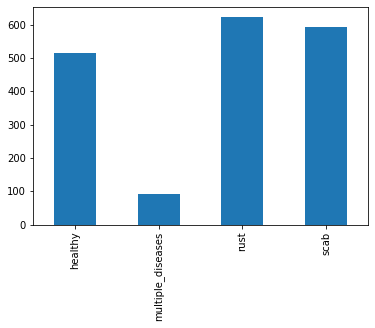

In [ ]:
train_df[labels].sum().plot(kind='bar')

### Load Data

In [ ]:
train_df['label'] = train_df[labels].idxmax(1); train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [ ]:
train_df['label'].value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock()), 
    getters=[ColReader('image_id', pref=img_dir, suff='.jpg'), ColReader('label')], 
    splitter=RandomSplitter(valid_pct=0.1, seed=random_seed),
    item_tfms=Resize(img_size),
    batch_tfms=aug_transforms(size=img_size, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True)
)

In [ ]:
dls = db.dataloaders(source=train_df, bs=bs)

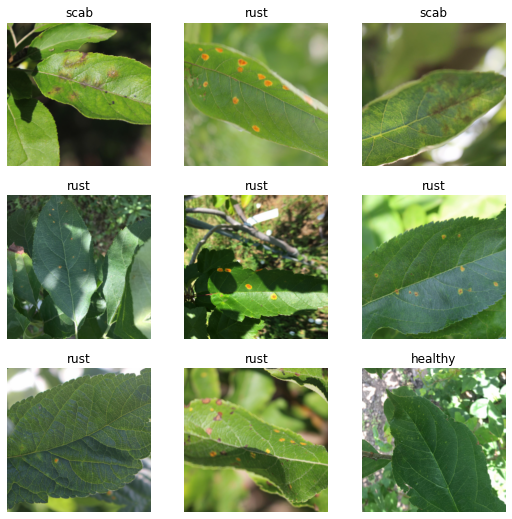

In [ ]:
dls.show_batch()

## Metric

In [ ]:
# reference: https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

def comp_metric(preds, targs, labels=range(len(labels))):
    # One-hot encode targets
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

## Training

In [ ]:
learn = cnn_learner(
    dls, arch, 
    loss_func=LabelSmoothingCrossEntropy(),
    metrics=[accuracy, AccumMetric(comp_metric, flatten=False)]
)#.to_fp16()

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=1.5848931980144698e-06)

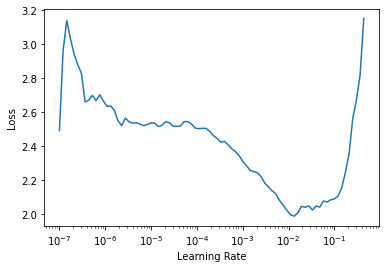

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.475168,5.458385,0.527473,0.787204,01:56
1,1.192656,0.748106,0.840659,0.917346,01:57
2,0.743366,0.569127,0.912088,0.943159,01:57
3,0.594158,0.518234,0.934066,0.943387,01:57


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(8, slice(3e-4, lr))

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.634279,1.354792,0.686813,0.870368,02:16
1,0.714085,1.233205,0.571429,0.788863,02:16
2,0.751155,0.603942,0.917582,0.931144,02:16
3,0.700458,0.550322,0.928571,0.956166,02:15
4,0.620101,0.543284,0.923077,0.930026,02:15
5,0.587732,0.520043,0.934066,0.964852,02:16
6,0.565468,0.491615,0.939560,0.972312,02:16
7,0.512787,0.490270,0.934066,0.968130,02:16


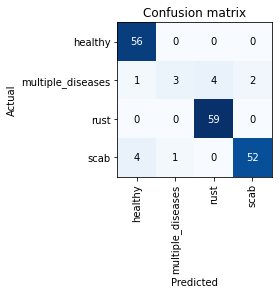

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

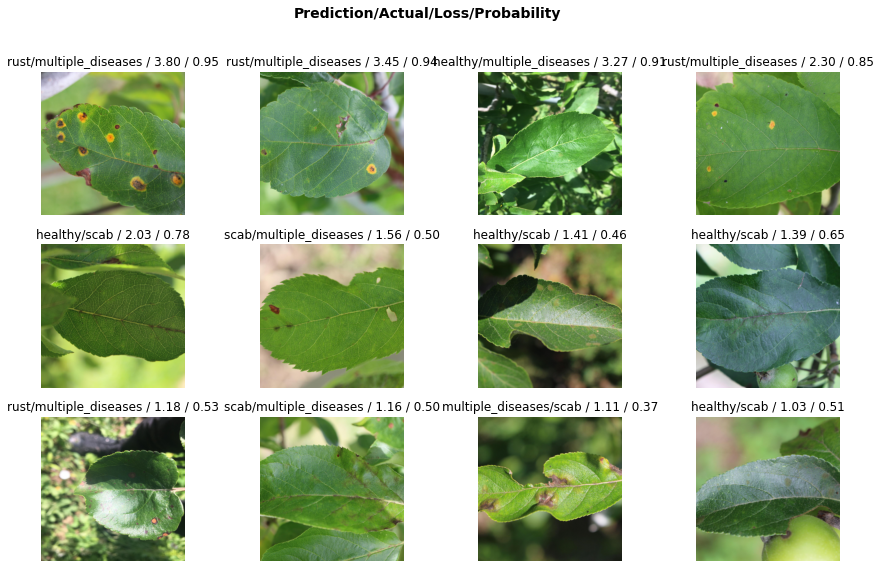

In [ ]:
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

## Submission

In [ ]:
test_df = pd.read_csv(data_dir/'test.csv')
test_dl = dls.test_dl(test_df)

In [ ]:
test_preds, _ = learn.get_preds(dl=test_dl)

KeyboardInterrupt: ignored

In [ ]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=labels)], axis=1)

## ToDo

- add submission
- consider multi-label classification
- multi-label k-fold cross-validation
- add data augmentation
- try over-sampling
- try other architetcures (e.g. ResNet-50, DenseNet)
- freeze/unfreeze training
- label smoothing cross entropy
- use to_fp16
- AccumMetric
- factoring the multiple_disease label data by different factors
- in the above learner, it confuses btw rusty/multiple_disease and scab/healthy (maybe we can look into this also)

## References

- https://www.kaggle.com/hamonk/plant-pathology-fastai
- https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763
- https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152
- https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb
- https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb
- https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data
- https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models
- https://www.kaggle.com/pestipeti/plant-pathology-2020-pytorch
- https://www.kaggle.com/parulpandey/overview-of-popular-image-augmentation-packages
- https://www.kaggle.com/akasharidas/plant-pathology-2020-in-pytorch
- https://www.kaggle.com/aziz69/efficientnetb7-tpu-tta-top-1
- https://www.kaggle.com/victorlouisdg/plant-pathology-opencv-background-removal
- https://www.kaggle.com/basu369victor/cycle-gan-to-balance-imbalanced-diseased-leaves
- https://www.kaggle.com/abdilatifssou/sample-use-of-efficientnetb7-achieved-97-8
- https://www.kaggle.com/dataraj/fastai-tutorial-for-image-classification
- https://www.kaggle.com/pestipeti/eda-plant-pathology-2020
- https://www.kaggle.com/a03102030/plant-pathology-2020-resnet50
- https://www.kaggle.com/welkinfeng/plant-pathology-pytorch-efficientnet-b4-gpu
- https://www.kaggle.com/dimakyn/classification-densenet201-efficientnetb7
- https://www.kaggle.com/jimitshah777/bilinear-efficientnet-focal-loss-label-smoothing
- https://www.kaggle.com/piantic/pytorch-tpu
- https://www.kaggle.com/aryaprince/pytorch-model
- https://www.kaggle.com/parulpandey/eda-histograms-color-spaces-masking
- https://www.kaggle.com/piantic/plant-pathology-2020-pytorch-for-beginner
- https://www.kaggle.com/ronyroy/effnet-fastai-folds-x5
- https://www.kaggle.com/otzhora/fastai-models-experiments
- https://www.kaggle.com/davidhiggins/fastai-with-resnet50
- https://www.kaggle.com/muellerzr/resnet152-with-tta-and-fine-tune-fastai2
- https://www.kaggle.com/lextoumbourou/pp-2020-adversarial-validation
- https://www.kaggle.com/hamonk/plant-pathology-fastai
- https://www.kaggle.com/salilm23/plants-fastai
- https://www.kaggle.com/urayukitaka/image-pre-processing-and-densenet
- https://www.kaggle.com/sovitrath/pytorch-effcientnet-b3-baseline
- https://www.kaggle.com/kmldas/efficientnet-b7-fastai2-for-multiclass-gpus
- https://www.kaggle.com/datadote/plants2020-fastai2
- https://www.kaggle.com/mehdislim01/transfer-learning-agressive-learning-schedule
- https://www.kaggle.com/amankimothi100/plant-pathology-fastai2-starter-with-resnet152
- https://www.kaggle.com/lov4jin/densenet-imagenet-pretrained-vs-retrained-gradcam
- https://www.kaggle.com/rkgosar/plant-pathology-with-pandas-cv2-keras
- https://www.kaggle.com/nickteim/fast-ai-v3-plant-pathology1
- https://www.kaggle.com/sonujha090/fastai-plant-pathlogy
- https://www.kaggle.com/sajidali22/fastai-resnet34
- https://www.kaggle.com/rupeish26/plant-fastai
- https://www.kaggle.com/v3dsingh/fast-ai-plant-pathology
- https://www.kaggle.com/julenarizaga/data-balancing-model-with-data-augmentation
- https://www.kaggle.com/sakshamaggarwal/basic-pytorch-pretrained-models-ensemble
- https://www.kaggle.com/muellerzr/plant-pathology-fastai2-exploration
- https://www.kaggle.com/lextoumbourou/plant-2020-cutmix-tpu
- https://www.kaggle.com/akashsuper2000/classification-densenet201-efficientnetb7
- https://github.com/bam098/plant_pathology/blob/main/plant_pathology_basic.ipynb
- https://github.com/bam098/plant_pathology/blob/main/WIP_misza222_plant_pathology_baseline.ipynb
- https://github.com/bam098/plant_pathology/blob/main/plant_pathology_basic_3_classes.ipynb